# Make a simple dataset for PCA learning

This is a very simple notebook to create a couple of datasets for testing out PCA. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Question 1: 1D PCA example - doing it by hand

In this problem we will do 1D PCA on a dataset without using the convenient functions in `sklearn`. To do this, we first need to create some fake data. After that we need to follow the steps detailed in the lecture notes. To summarise, these are:

 - If necessary, transform data to have zero mean and perhaps unit variance.
 - Calculate the covariance matrix of the data, $C_x$.
 - Find the eigenvalues & eigenvectors of the covariance matrix.
 - Decide which eigenvalues are worth keeping and put these into a feature matrix, $M$.
 - Use $M$ to calculate the new coordinates.
 - If appropriate, use $M$ to go back to the original coordinate system, undoing the scaling and shift if applied.
 
 So let us see how do to these steps.

### a) create a fake dataset.

We want a slope of 2.1 and an intercept of 1.4 and will draw $x$ values from $-1.4$ to $4.0$. 

In [3]:
def make_random_2D_data(N=40, dy = 0.3, dx = 0.3):
    slope = 2.1
    intercept = 1.4
    xmin = -1.4
    xmax = 4.0
    
    x_true = np.random.uniform(xmin, xmax, size=N)
    y_true = slope*x_true + intercept
    
    x = x_true + np.random.normal(0, dx, size=N)
    y = y_true + np.random.normal(0, dy, size=N)
    
    return x, y
    

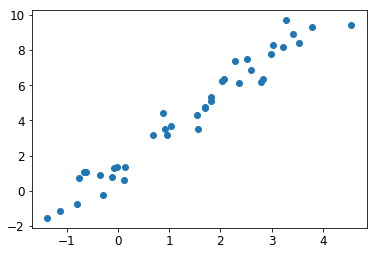

In [4]:
x, y = make_random_2D_data()
df = pd.DataFrame({'x': x, 'y': y})
plt.scatter(x, y)


In [5]:
df.to_csv('x-vs-y-for-PCA.csv')

### b) Whiten the data.

In other words, subtract off the means and divide by the standard deviation. Note that I store the offsets so that I can apply them again if needed. 

In [6]:
mean_x = np.mean(x)
mean_y = np.mean(y)
std_x = np.std(x)
std_y = np.std(y)
xw = (x-mean_x)/std_x
yw = (y-mean_y)/std_y

(-2, 2)

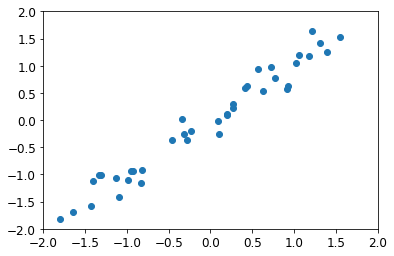

In [7]:
plt.scatter(xw, yw)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

### c) The covariance matrix

Next, we calculate the covariance matrix. This is actually trivial in `numpy` since the function `cov` does the job for us:

In [8]:
X = np.vstack([xw, yw])

In [9]:
C_x = np.cov(X)
C_x

array([[ 1.02564103,  1.00258992],
       [ 1.00258992,  1.02564103]])

What you see here is that this is very far from being diagonal, so we need to diagnoalise this. This also tells us that $x$ and $y$ are strongly linearly correlated (not surprising of course!).

### d) Eigenvectors & diagonalisation

We can calculate these easily using the `eig` function in `np.linalg`. This returns the eigenvalues and eigenvectors. We want both

In [10]:
lam, v = np.linalg.eig(C_x)

We can now print the eigenvalues and optionally also make a bar plot of them

Eigenvalues= [ 2.02823095  0.0230511 ]


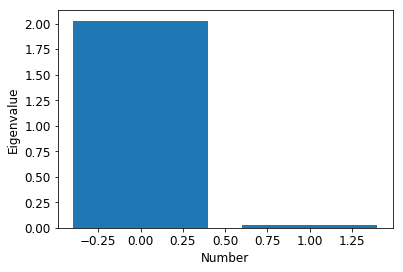

In [11]:

plt.bar(np.arange(len(lam)), lam)
plt.ylabel('Eigenvalue')
plt.xlabel('Number')
print "Eigenvalues=",lam

We can also print out the eigenvectors. The first of which encodes the direction the data varies the most. The returned array, $v$, is a 2D array, but we can unzip this into two individual vectors using the `zip` function.

In [12]:
v

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [13]:
ev1, ev2 = zip(*v)
ev1

(0.70710678118654746, 0.70710678118654746)

in other words, `ev1 = v[:, 0]`.

Let us overplot these vectors - first on the whitened data (easy)

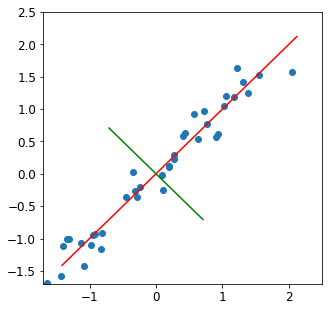

In [14]:
plt.scatter(xw, yw)
# s is a scale factor along the vector. 
s = np.linspace(-2, 3, 10)
# Perpendicular I want a bit less.
s_p = np.linspace(-1, 1, 10)
plt.plot(ev1[0]*s, ev1[1]*s, color='red')
plt.plot(ev2[0]*s_p, ev2[1]*s_p, color='green')
plt.xlim(-1.7, 2.5)
plt.ylim(-1.7, 2.5)
fig = plt.gcf()
fig.set_size_inches(5,5)

Now, we want to plot the vectors in the original space. To do that we need to invert our scalings above. Thus we need to calculate $x_p = x_w \sigma_x + \mu_x$.

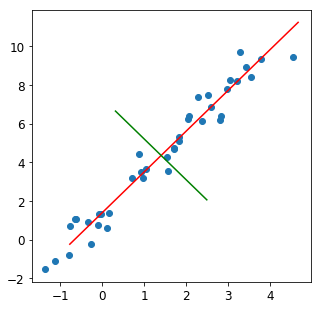

In [15]:
plt.scatter(x, y)
fig = plt.gcf()
fig.set_size_inches(5,5)

plt.plot(ev1[0]*s*std_x+mean_x, ev1[1]*s*std_y+mean_y, color='red')
plt.plot(ev2[0]*s_p*std_x+mean_x, ev2[1]*s_p*std_y+mean_y, color='green')


### e) Project data onto new axes

To do this we can multiply the data by the eigenvector matrix (`v`). 

In [16]:
pcs = np.zeros((2, len(xw)))
for i in range(len(xw)):
    pcs[:, i] = np.matmul(v.T, np.array([xw[i], yw[i]]).T)


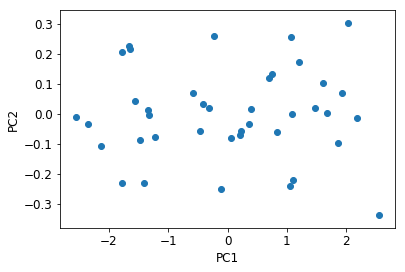

In [17]:
plt.scatter(pcs[0, :], pcs[1, :])
plt.xlabel('PC1')
plt.ylabel('PC2')

Next, let us remove one dimension. Thus our projection uses only ev1.

In [18]:
pc1 = np.zeros((len(xw)))
for i in range(len(xw)):
    pc1[i] = np.matmul(ev1, np.array([xw[i], yw[i]]).T)


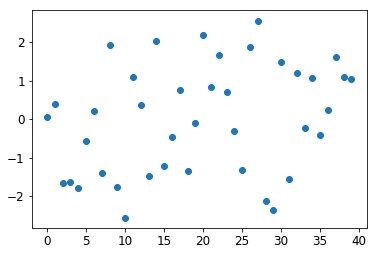

In [19]:
plt.scatter(np.arange(len(pc1)), pc1)

In [20]:
x_red, y_red = pc1*ev1[0], pc1*ev1[1]

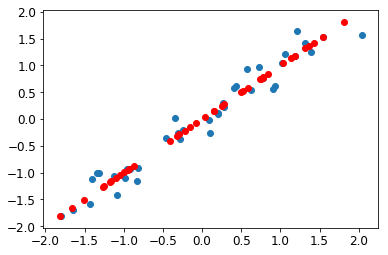

In [21]:
plt.scatter(xw, yw)
plt.scatter(x_red, y_red, color='red')

### f) Finally - do this using the PCA module

This will now use the `sklearn.project.PCA` function. It is best not to use `white=True` as it is then easier to understand what is done. Instead we can use the `sklearn.preprocessing.StandardScaler` function.


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Running the PCA fit with 2 components

Above we got all components and then projected down. Here we have to specify the number of components up front.

In [23]:
pca = PCA(whiten=False, n_components=2)

In [24]:
X = np.vstack([x, y]).T
scl = StandardScaler()
Xs = scl.fit_transform(X)
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

We can now get the eigenvectors the way we did above (although the components array here is the transpose of the above). 

In [25]:
ev1_1, ev2_1 = zip(*pca.components_.T)
ev1_1, np.array(ev1)*std_x

((-0.70710678118654735, -0.70710678118654768),
 array([ 1.08956777,  1.08956777]))

and we see that these are the same eigenvectors we found above. Thus plotting them would give the same result.

### Projecting to 1D.

Here we will now see the way to project back. But first we will just see the projection onto the new PC axes. In this case we have only one, so we plot that against the index.

In [26]:
pca_1D = PCA(whiten=False, n_components=1)

pca_1D.fit(Xs)

pc1 = pca_1D.transform(Xs)

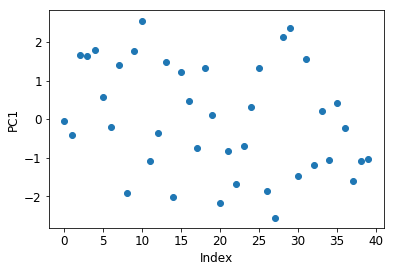

In [27]:
plt.scatter(np.arange(len(pc1)), pc1)
plt.xlabel('Index')
plt.ylabel('PC1')

Now, to do the inverse transform back to our whitened data, we can use the `inverse_transform` function. To use this we need to provide the PC axes in an array back. Since we have only one PC here, we have to add an extra dimension at the end.


In [28]:
Xp = pca_1D.inverse_transform(pc1)

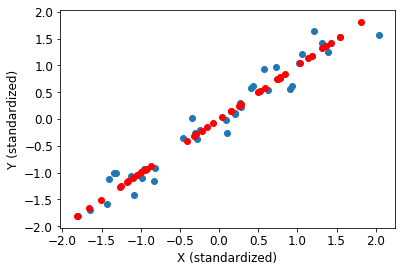

In [29]:
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.scatter(Xp[:, 0], Xp[:, 1], color='red')
plt.xlabel('X (standardized)')
plt.ylabel('Y (standardized)')

If you want to go back to the original, non-standardized space, you need to `scl` object:

In [30]:
Xp_orig = scl.inverse_transform(Xp)

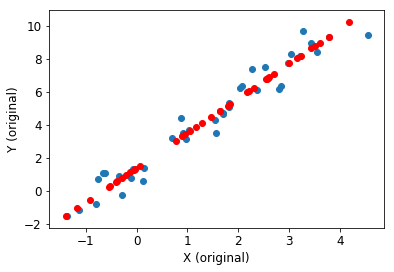

In [31]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(Xp_orig[:, 0], Xp_orig[:, 1], color='red')
plt.xlabel('X (original)')
plt.ylabel('Y (original)')

Now, you can also use the whitening option to the PCA, although the vectors that you get out will be a bit different because the normalisation is different. The end result when transforming back to the original space is the same however. 

In [32]:
pca_1Dw = PCA(whiten=True, n_components=1)
# Notice I use X here!
pca_1Dw.fit(X)
pc1w = pca_1Dw.transform(X)
Xpw = pca_1Dw.inverse_transform(pc1w)

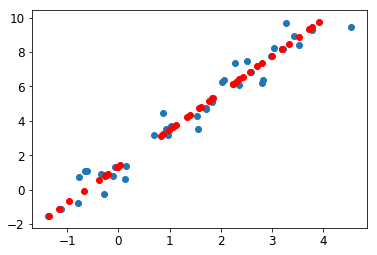

In [33]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(Xpw[:, 0], Xpw[:, 1], color='red')

## Question 2 - explore higher diemensional PCA

This write-up contains the actual code used to create the data (this was provided in a Python script with the problem set). It would require you to install `transforms3` but you can do that easily using `pip`. 

In [34]:
from transforms3d.euler import euler2mat, mat2euler


In [35]:
def make_simple_data_4D():
    """
    This creates the simple data underlying the full set.
    
    Here I create a sinusoidal curve in the x-y plane, and add noise around it in two further dimensions. 
    I rotate the x, y, z dimensions and then output this as well as the original coordinates.
    
    """
    N = 500
    # Not centred on 0 and they have a different extent
    xrange = [3, 7]
    yrange = [2, 6]
    
    dz = 0.1
    dw = 0.1

    np.random.seed(100)
    x = np.random.uniform(xrange[0], xrange[1], N)
    y = 4*np.sin(x*np.pi*2) # np.random.uniform(yrange[0], yrange[1], N)
    w = np.random.normal(0, dw, size=N)
    z = np.random.normal(0, dz, size=N)
    
    # Create the rotation matrix using Euler angles.
    x_angle = -np.pi/3.
    y_angle = -np.pi / 5.2
    z_angle = np.pi/4.5
    R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
    
    X = np.vstack([x, y, z])
    Xnew = np.matmul(R, X)
    
    xr = Xnew[0, :].squeeze()
    yr = Xnew[1, :].squeeze()
    zr = Xnew[2, :].squeeze()
    Xr = np.vstack([xr, yr, zr, w])
    X = np.vstack([x, y, z, w])
    
    df = pd.DataFrame(Xr.T, columns=('X', 'Y', 'Z', 'W'))
    dfo = pd.DataFrame(X.T, columns=('X', 'Y', 'Z', 'W'))
    
    return df, dfo, Xr.T, X.T


In [36]:
df, dfo, Xn, Xo = make_simple_data_4D()

In [53]:
dfo.to_csv('xyzw-for-PCA-no-rotation.csv')
df.to_csv('xyzw-for-PCA.csv')

### Visualisations

It is important to look at the data before doing something more. One thing that is useful here is to actually set the axis ranges to span the same region - that will make it easier to understand what is going on. But first a straight pairplot of the non-rotated dataset. 

Note that I keep the returned value of the pairplot because this is what we need to modify the plot afterwards. In normal use I would modify it directly but here I make two separate plots to help visualisation.

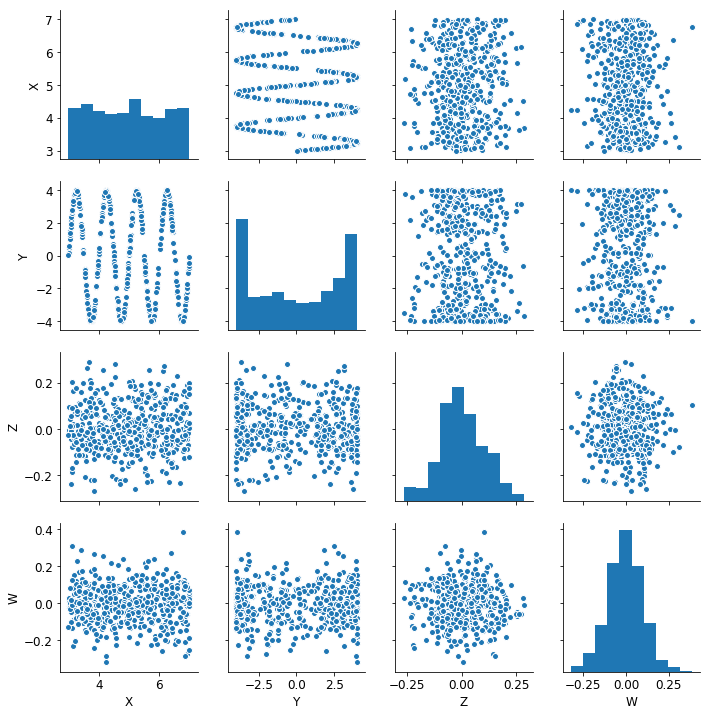

In [56]:
g = sns.pairplot(dfo)

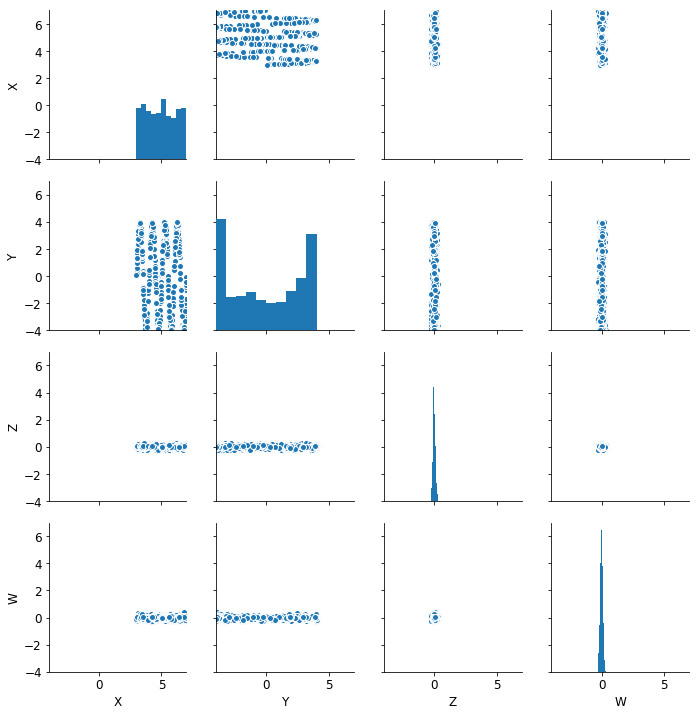

In [58]:
g = sns.pairplot(dfo)
g.set(ylim=(-4, 7), xlim=(-4, 7))

It is also useful to see the rotated data as that is what we will actually work with.

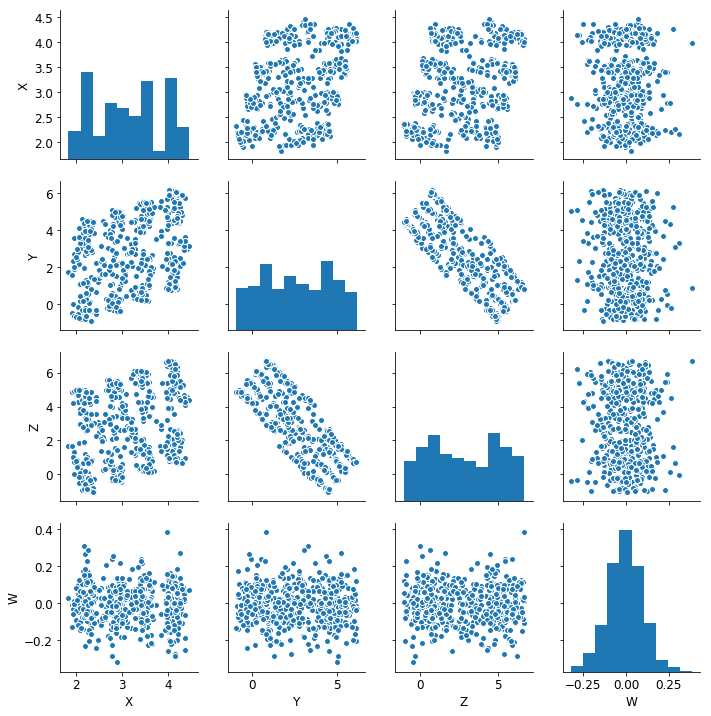

In [59]:
sns.pairplot(df)

## 2a) Run PCA

We will use the `StandardScaler` functionality in `sklearn` to standardize the data. We need to keep the `StandardScaler` to be able to reverse this later. Since I explicitly scale the data, there is no need to whiten the data in the PCA call.

In [65]:
from sklearn.decomposition import PCA
scl = StandardScaler()
Xs = scl.fit_transform(Xn)

In [73]:
def var_plot(pca, ax=None, title=''):
    xtmp = np.arange(len(pca.explained_variance_))
    ytmp = pca.explained_variance_ratio_
    
    if ax is None:
        fig, ax = plt.subplot(111)
        
    ax.bar(xtmp, ytmp)
    ax.set_title(title)
    ax.set_xlabel('Component')
    return ax

In [63]:
pca = PCA(whiten=False, n_components=4)
# This is used for the standardised data
pca_std = PCA(whiten=False, n_components=4)

Here I can choose whether to fit the standardized data (Xs), or the original (Xn). We could do this with a function but I like doing it step by step, so that is what we do here.

In [75]:
pca.fit(Xn)
pca_std.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### The effective dimension

The simplest way to define this is to look at the explained variance of the data. This is shown below, and as you can see you reach clearly two different conclusions depending on whether the data is standardised or not.

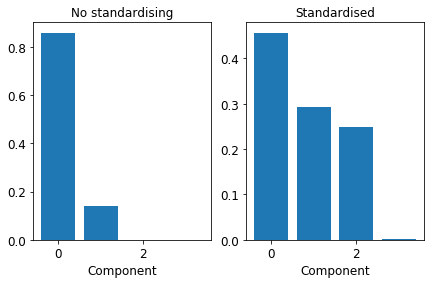

In [76]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 4))
var_plot(pca, axes[0], title='No standardising')
var_plot(pca_std, axes[1], title='Standardised')

### Transforming the data & visualising them.

First we do the full 4D case.

In [80]:
Xtrans = pca.transform(Xn)
Xtrans_std = pca_std.transform(Xs)

In [81]:
dft = pd.DataFrame(Xtrans, columns=('PC1', 'PC2', 'PC3', 'PC4'))
dft_std = pd.DataFrame(Xtrans_std, columns=('PC1', 'PC2', 'PC3', 'PC4'))

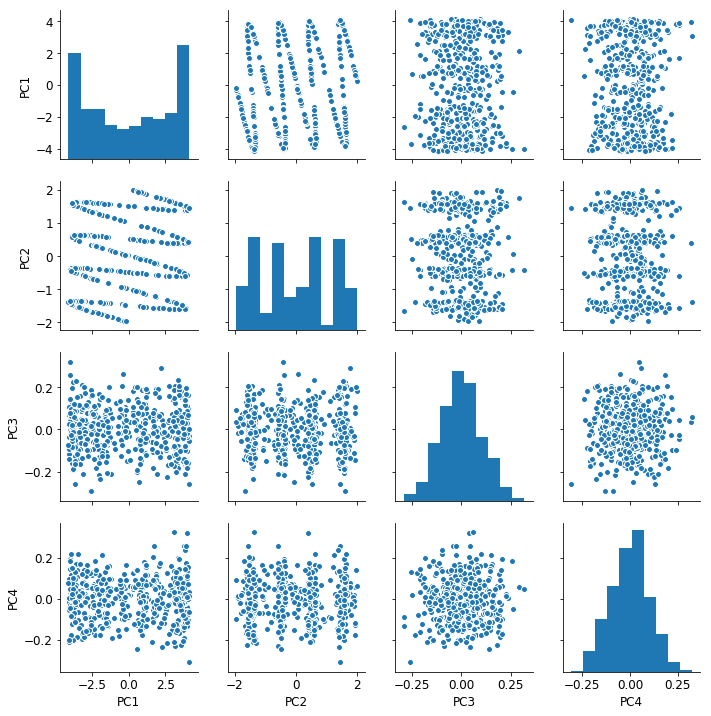

In [83]:
sns.pairplot(dft)

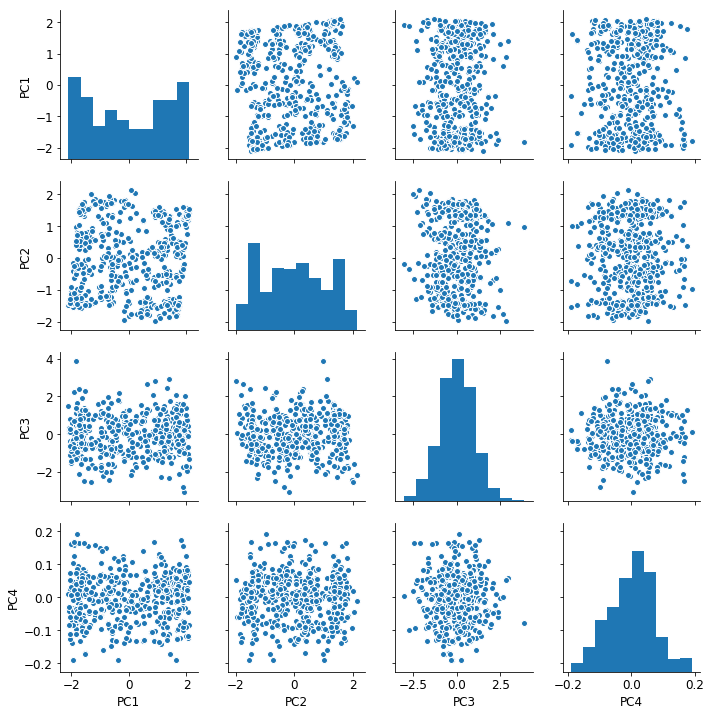

In [82]:
# The standardised data
sns.pairplot(dft_std)

### Next, keep only two dimensions

Again I'll do this for both standardised and non-standardised data.

In [87]:
pca2D = PCA(whiten=False, n_components=2)
Xtrans = pca2D.fit_transform(Xn)
Xp = pca2D.inverse_transform(Xtrans)


pca2D_std = PCA(whiten=False, n_components=2)
Xtrans_std = pca2D.fit_transform(Xs)
Xp_std = pca2D.inverse_transform(Xtrans_std)

In [88]:
dft = pd.DataFrame(Xtrans, columns=('PC1', 'PC2'))
dft_std = pd.DataFrame(Xtrans_std, columns=('PC1', 'PC2'))

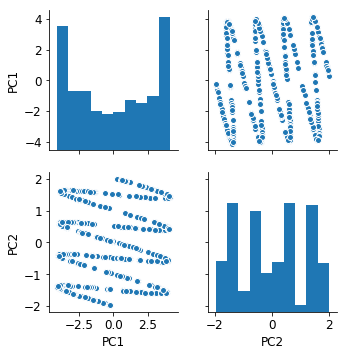

In [90]:
sns.pairplot(dft)

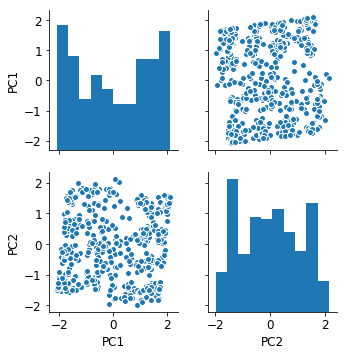

In [91]:
sns.pairplot(dft_std)

So, we can see that the non-standardised data allow us to get back to the important structure in the data much better. The reason for this is seen in the figure far above where the ranges were set equal on each axis. There you can see that z and w span very small ranges and therefore explain very little of the variance. However if you standardise you data, the ranges of all variables will be close to -2 to 2 and  the difference between the dimensions is much less. 

This is of course a bit of an artificial dataset and it has complex non-linearities but it is useful to look at this and remember that you should not use standarisation blindly - even if it is often a good idea for stability reasons at the very least.

# Question 3 - PCA on the fundamental plane

Question a) needs you to get the catalogue from Vizier. This is best done manually (the Vizier catalogue can be queried from Python, but the search facility is not as powerful as the direct interface). 

I found this at http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/MNRAS/327/265&-to=3

I made sure to tick the 'All columns' box and unlimited number of columns. As the dataset is pretty small, I downloaded a VOTable.

In [99]:
from astropy.table import Table

def load_SMACS_data():
    """
    Load the data from Hudson et al (2001)
    """
    fname = '../Datafiles/SMACIII-Hudson_etal_2001.vot'
    t = Table().read(fname, table_id='J_MNRAS_327_265_table7')
    return t

In [154]:
t = load_SMACS_data()

In [125]:
# We need a subset of this. But only the good data.
logRe = t['logRe']
mu_e = t['__mu_e']
logsigma = t['logsigma']
ok, = np.where(np.isfinite(logRe) & np.isfinite(mu_e) & 
               np.isfinite(logsigma))

# This gymnastic can probably be avoided but works - this turns the table
# columns into honest-to-god ndarrays
logRe = logRe[ok].filled().data
mu_e = mu_e[ok].filled().data
logsigma = logsigma[ok].filled().data

We have the size in arcseconds so we also need to convert this to kpc.

In [139]:
from astropy.cosmology import Planck15
import astropy.units as u

In [145]:
Re_kpc = Planck15.kpc_comoving_per_arcmin(t['cz']/3e5)*(10.0**logRe/60.)*u.arcmin
logRe_kpc = np.log10(Re_kpc.to(u.kpc).value)

For the data to fit we use physical size for the radius.

In [155]:
X = np.vstack([logRe_kpc, mu_e, logsigma])
df = pd.DataFrame(X.T, columns=('logRe', 'mu_e', 'logsigma'))

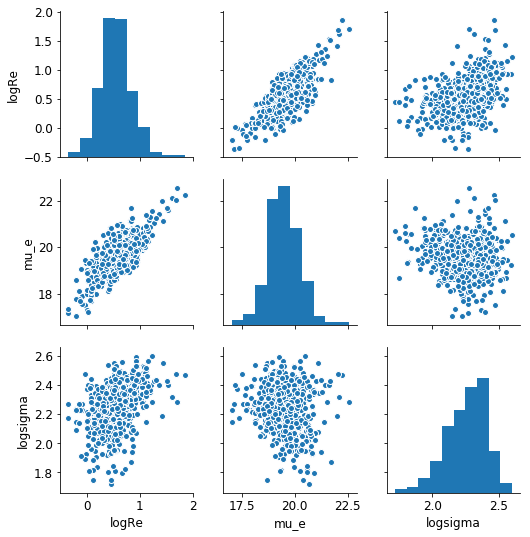

In [156]:
sns.pairplot(df)

## b) Scatter around reference plane

This is the plane taken from Jørgensen, Franx & Kjærgard (1996)



In [130]:
def jfk_plane(logsigma, mu_e):
    # Calculate the log Re for this logsigma, logmu
    
    logIe = -0.4*mu_e
    val = 1.24*logsigma - 0.82*logIe
    
    return val

In [131]:
logRe_plane = jfk_plane(logsigma, mu_e)

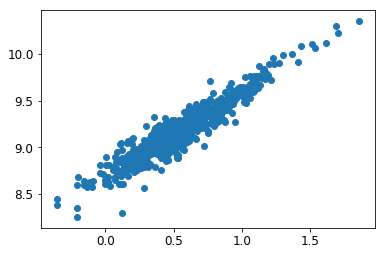

In [147]:
plt.scatter(logRe_kpc, logRe_plane)

### Find the scatter

To find the scatter we can fit a linear relation to the data.

In [148]:
from sklearn.linear_model import LinearRegression

In [149]:
res = LinearRegression().fit(logRe_kpc[:, np.newaxis], logRe_plane)

In [150]:
logRe_pred = res.predict(logRe_kpc[:, np.newaxis])

In [153]:
scatter = np.std(logRe_plane-logRe_pred)
print "The scatter around the best-fit plane is: {0:.3f}".format(scatter)

The scatter around the best-fit plane is: 0.098


## Run a PCA on the data.

In this case we are interested in the least important eigenvector as that should give the perpendicular to the plane.

In [162]:
pca = PCA(whiten=False, n_components=3)
pca.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [170]:
pca.explained_variance_ratio_

array([ 0.91867508,  0.07593154,  0.00539339])

Now get the eigenvectors - we are interested in ev3

In [167]:
ev1, ev2, ev3 = zip(*pca.components_.T)

In [171]:
ev3

(0.58154350380308817, -0.19816712448413387, -0.78901010383778847)

To convert this to the form we are used to, we need to first recall that the order of variables was `logRe_kpc`, `mu_e`, `logsigma`. Thus we want a unit first element:

In [172]:
ev3/ev3[0]

array([ 1.        , -0.34076062, -1.35675164])

So we have

$$\log R_e = 1.356 \log \sigma + 0.341 \mu_e = 1.356 \log \sigma - 0.8525 I_e$$

We can finish off by calculating the scatter around this line:

In [185]:
b = -ev3[1]/ev3[0]
a = -ev3[2]/ev3[0]
ypred = a*logsigma + b*mu_e

In [187]:
res_pca = LinearRegression().fit(logRe_kpc[:, np.newaxis], ypred)
yline_pca = res_pca.predict(logRe_kpc[:, np.newaxis])


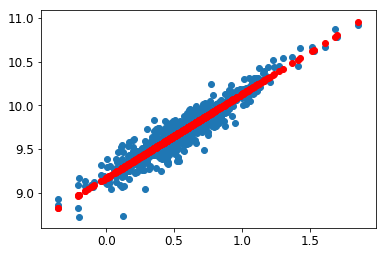

In [188]:
plt.scatter(logRe_kpc, ypred)
plt.scatter(logRe_kpc, yline_pca, color='red')

In [189]:
scatter = np.std(ypred-yline_pca)
print "The scatter around the PCA-determined plane is: {0:.3f}".format(scatter)

The scatter around the PCA-determined plane is: 0.105


So in the end we got a slightly higher scatter in this unsupervised approach.